Ноутбук кластеризует данные с помощью моуля dclust, который предоставляет код для обработки данных и обучения реккурентного автоэнкодера

In [1]:
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from umap import UMAP
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
import os

In [2]:
from dclust.processing import collect_data
from dclust.model.autoencoder import TRAE
from dclust.model.trainer import Trainer

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
PRIMARY_PATH = 'PUT_PATH_TO_DATA'
test_df = pd.read_csv(os.path.join(PRIMARY_PATH, 'sample_submission.csv'))

In [5]:
filenames = np.array(test_df.wav_path.tolist())

In [6]:
data = collect_data(filenames, PRIMARY_PATH+'val')

  0%|          | 23/55200 [00:00<04:08, 222.24it/s]

100%|██████████| 55200/55200 [02:09<00:00, 427.43it/s]


In [7]:
dataset = TensorDataset(data)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False) # чтобы сохранить порядок для сопоставления с filenames

In [8]:
device = 'cuda:3'
trainer = Trainer(TRAE(2, device=device).to(device),
                  learning_rate=5e-4,
                  device=device)

In [9]:
losses_history = trainer.train(10, train_dataloader)

1 / 10 | Loss: 0.10628426109515088
2 / 10 | Loss: 0.07535489201373048
3 / 10 | Loss: 0.06628669464263551
4 / 10 | Loss: 0.06166973138532384
5 / 10 | Loss: 0.05890414658351127
6 / 10 | Loss: 0.057057180667462244
7 / 10 | Loss: 0.05578262563514268
8 / 10 | Loss: 0.05476783479316762
9 / 10 | Loss: 0.053989004507781733
10 / 10 | Loss: 0.05347961179160989


In [10]:
features = trainer.extract_features(eval_dataloader).cpu().numpy()

In [11]:
low_dim = UMAP(metric='cosine').fit_transform(features)

In [12]:
big_clusters = MeanShift(bandwidth=4).fit_predict(low_dim)

<AxesSubplot:>

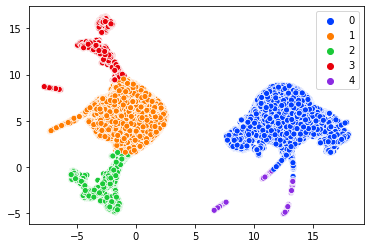

In [13]:
palette = sns.color_palette("bright", np.unique(big_clusters).shape[0])
sns.scatterplot(
    low_dim[:, 0], low_dim[:, 1],
    hue=big_clusters, palette=palette,
    legend='full'
)

Основная гипотеза в том, что каждый из этих кластеров содержит все из существующих классов, но их можно разделить, 
сделав повторную кластеризацию по кажду из "больших" кластеров

In [ ]:
chunks = []
for class_id in np.unique(big_clusters):
    mask = (big_clusters == class_id)
    data_chunk = low_dim[mask]
    cluster_chunk = GaussianMixture(3).fit_predict(data_chunk)
    chunks.append((
        filenames[mask], cluster_chunk
    ))

In [29]:
chunks[0][1]

array([5, 0, 5, 0, 3, 4, 4, 3, 3, 2, 4, 0, 3, 3, 0, 0, 2, 4, 2, 3, 4, 3,
       3, 3, 4, 0, 1, 1, 3, 1, 0, 4, 1, 3, 0, 1, 1, 2, 3, 3, 4, 2, 0, 1,
       2, 1, 1, 1, 2, 5, 2, 5, 4, 2, 1, 2, 4, 3, 1, 2, 4, 1, 5, 1, 3, 3,
       0, 2, 4, 0, 4, 0, 0, 1, 2, 5, 3, 2, 2, 3, 3, 0, 4, 1, 3, 3, 5, 0,
       2, 3, 3, 4, 3, 3, 2, 4, 3, 4, 5, 5, 1, 1, 1, 1, 4, 0, 2, 1, 2, 3,
       3, 5, 3, 5, 5, 2, 3, 5, 2, 3, 5, 3, 3, 0, 5, 1, 0, 1, 4, 4, 3, 4,
       0, 0, 3, 2, 1, 1, 1, 0, 5, 2, 3, 3, 3, 0, 2, 3, 2, 3, 0, 5, 1, 3,
       3, 4, 5, 5, 5, 4, 0, 2, 1, 1, 5, 3, 4, 0, 1, 5, 4, 5, 1, 2, 2, 3,
       3, 4, 5, 4, 5, 3, 2, 4, 5, 1, 5, 4, 0, 0, 3, 5, 2, 3, 0, 3, 2, 4,
       5, 5, 2, 1, 4, 5, 1, 0, 4, 4, 1, 5, 1, 3, 1, 1, 4, 2, 2, 3, 3, 0,
       0, 4, 0, 5, 1, 4, 4, 0, 4, 3, 0, 2, 4, 3, 3, 1, 2, 2, 5, 1, 3, 5,
       1, 5, 1, 3, 3, 3, 3, 1, 0, 0, 5, 5, 2, 4, 4, 2, 5, 4, 1, 3, 1, 0,
       1, 5, 2, 0, 1, 3, 2, 2, 5, 5, 3, 3, 3, 3, 3, 1, 4, 1, 3, 0, 1, 3,
       5, 1, 1, 4, 2, 3, 0, 3, 1, 0, 1, 4, 2, 5, 1,